库的导入

In [1]:
import os
from pathlib import Path
import numpy as np
import skimage.exposure
import warnings
from io import StringIO
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import skimage.segmentation




In [8]:

def _read_roi(path: Path, shape) -> coo_matrix:
    """
    读取 ENVI 软件导出 ROI 文件的 txt 文件，生成一个稀疏矩阵，表示每个像素点的类别标签。
    
    :param path: 文件路径，ENVI ROI 文件的路径
    :param shape: 图像的形状（height, width）
    :return: 一个稀疏矩阵，非零值表示像素点的类别标签
    """
    warnings.simplefilter("ignore", category=UserWarning)  # 忽略 loadtxt 的警告
    data = []
    rows = []
    cols = []
    current_label = 0
    buffer = ""

    with open(path, 'r') as f:
        for line in f:
            # 判断是否为新 ROI 的分割点
            if line.strip() == "" or line.startswith(";") or "ROI" in line:
                if buffer:  # 如果缓冲区有内容，解析为坐标数据
                    roi_data = np.loadtxt(StringIO(buffer), usecols=(2, 1), dtype=int)
                    if roi_data.size > 0:
                        r, c = roi_data.T
                        rows.extend(r)
                        cols.extend(c)
                        data.extend([current_label] * len(r))
                    buffer = ""  # 清空缓冲区
                # 如果遇到 ROI name 行，增加类别标签
                if "ROI name" in line:
                    current_label += 1
            else:
                buffer += line  # 将数据加入缓冲区

        # 处理最后一个 ROI
        if buffer:
            roi_data = np.loadtxt(StringIO(buffer), usecols=(2, 1), dtype=int)
            if roi_data.size > 0:
                r, c = roi_data.T
                rows.extend(r)
                cols.extend(c)
                data.extend([current_label] * len(r))

    warnings.resetwarnings()

    # 创建稀疏矩阵
    img = coo_matrix((data, (rows, cols)), shape=shape, dtype=int)
    return img


def load_houston2013(data_path: Path):
    """
    从本地路径加载 Houston2013 数据集。

    :param data_path: 数据集的根目录路径。
    :return: (casi, lidar, train_truth, test_truth, info)
    """
    FILES_PATH = data_path
    assert FILES_PATH.exists(), f"{FILES_PATH} does not exist. Please check the path."

    # 加载图像数据
    lidar = skimage.io.imread(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_LiDAR.tif')[np.newaxis, :, :]  # (1, 349, 1905)
    casi = skimage.io.imread(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_CASI.tif').transpose(2, 0, 1)   # (144, 349, 1905)

    # 加载训练集和测试集的真值
    train_truth = _read_roi(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_Samples_TR.txt', (349, 1905))
    test_truth = _read_roi(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_Samples_VA.txt', (349, 1905))

    # 数据集元信息
    info = {
        'n_band_casi': 144,
        'n_band_lidar': 1,
        'width': 1905,
        'height': 349,
        'label_dict': {
            1: 'Healthy grass',
            2: 'Stressed grass',
            3: 'Synthetic grass',
            4: 'Trees',
            5: 'Soil',
            6: 'Water',
            7: 'Residential',
            8: 'Commercial',
            9: 'Road',
            10: 'Highway',
            11: 'Railway',
            12: 'Parking Lot 1',
            13: 'Parking Lot 2',
            14: 'Tennis Court',
            15: 'Running Track',
        }
    }

    return casi, lidar, train_truth, test_truth, info

def merge_train_test(train_truth, test_truth, shape):
    """
    合并训练集和测试集稀疏矩阵为一个新的训练集矩阵。
    
    参数:
        train_truth: coo_matrix, 原始训练集稀疏矩阵
        test_truth: coo_matrix, 原始测试集稀疏矩阵
        shape: tuple, 数据的形状 (height, width)
        
    返回:
        merged_truth: coo_matrix, 合并后的训练集稀疏矩阵
    """
    # 合并行、列和数据
    merged_rows = np.concatenate([train_truth.row, test_truth.row])
    merged_cols = np.concatenate([train_truth.col, test_truth.col])
    merged_data = np.concatenate([train_truth.data, test_truth.data])
    
    # 创建新的稀疏矩阵
    merged_truth = coo_matrix((merged_data, (merged_rows, merged_cols)), shape=shape)
    return merged_truth

def apply_pca_train_only(hsi_data, train_truth, num_components=40):
    """
    使用训练区域的光谱数据训练 PCA 模型，并应用到整个数据集。
    
    参数:
        hsi_data: numpy.ndarray, 高光谱图像数据, 形状为 [C, H, W]
        train_truth: coo_array, 训练区域的稀疏矩阵，表示训练样本的位置
        num_components: int, 保留的主成分数量
        
    返回:
        pca_data: numpy.ndarray, PCA 降维后的数据，形状为 [num_components, H, W]
        explained_variance_ratio: PCA 的累计解释方差比
    """
    c, h, w = hsi_data.shape  # 高光谱数据的形状
    rows, cols = train_truth.row, train_truth.col  # 提取训练区域的行列索引
    
    # 提取训练区域的光谱数据 [num_samples, num_channels]
    train_spectra = hsi_data[:, rows, cols].T  # 转置为 [num_samples, num_channels]
    
    # 在训练区域数据上拟合 PCA
    pca = PCA(n_components=num_components)
    pca.fit(train_spectra)  # 仅在训练区域数据上训练 PCA
    
    # 转换整个数据集 [C, H, W] -> [H×W, C]
    reshaped_data = hsi_data.reshape(c, -1).T  # [H×W, C]
    reduced_data = pca.transform(reshaped_data)  # 降维 [H×W, num_components]
    
    # 恢复为原始图像的形状 [num_components, H, W]
    pca_data = reduced_data.T.reshape(num_components, h, w)  # [num_components, H, W]
    
    return pca_data, pca.explained_variance_ratio_

def superpixel_segmentation(hsi_data, num_superpixels=100):
    """
    使用 SLIC 超像素分割对 HSI 进行分割。

    参数:
        hsi_data: numpy.ndarray, 形状为 (C, H, W)
        num_superpixels: 生成的超像素数量
        
    返回:
        labels: 超像素标签矩阵，形状为 (H, W)
    """
    # 先用 PCA 提取第一主成分
    first_pc = PCA(n_components=1).fit_transform(hsi_data.reshape(hsi_data.shape[0], -1).T)
    first_pc = first_pc.reshape(hsi_data.shape[1:])  # 变成 (H, W)

    # 修正错误：复制 3 通道，使其符合 SLIC 需 
    first_pc_rgb = np.stack([first_pc] * 3, axis=-1)  # 变成 (H, W, 3)

    # 正确调用 skimage.segmentation.sli 
    labels = skimage.segmentation.slic(first_pc_rgb, n_segments=num_superpixels, compactness=10, start_label=0, channel_axis=-1)
    
    return labels



def compute_superpixel_pca(hsi_data, superpixel_labels, merged_train_truth):
    """
    仅在训练区域计算每个超像素的局部 PCA，并返回降维后的特征。

    参数:
        hsi_data: numpy.ndarray, 形状为 (B, H, W)
        superpixel_labels: numpy.ndarray, 形状为 (H, W)
        merged_train_truth: coo_matrix, 训练区域掩码
        num_components: int, PCA 维度
        
    返回:
        superpixel_pca_map: numpy.ndarray, 形状为 (num_components, H, W)
    """
    h, w = superpixel_labels.shape
    c = hsi_data.shape[0]  # 通道数，比如 144
    superpixel_pca_map = np.zeros((c, h, w))  # 保留全通道

    superpixel_pca_dict = {}

    rows, cols = merged_train_truth.row, merged_train_truth.col  # 只取训练区域

    unique_labels = np.unique(superpixel_labels)
    for label in unique_labels:
        mask = (superpixel_labels == label)

        # 只选择该超像素块内，同时在训练区域的像素
        train_mask = np.logical_and(mask, merged_train_truth.toarray() > 0)
        if np.sum(train_mask) == 0:  # 该超像素区域没有训练数据，跳过
            continue

        pixels = hsi_data[:, train_mask].T  # 取出该超像素块的训练样本 (num_samples, num_channels)

        superpixel_pca_dict[label] = pixels.T  # shape: (num_channels, N)

        
        # 赋值到整个超像素区域

        for i in range(c):
            superpixel_pca_map[i, mask] = np.mean(pixels[:, i])


    return superpixel_pca_map, superpixel_pca_dict




def split_cube(hsi_cube):
    """
    将高光谱立方块沿通道维度均匀切分。
    参数:
        hsi_cube: torch.Tensor, 形状为 [H, W, C]
    返回:
        hsi_cube_a, hsi_cube_b: 两个子立方块
    """
    _, _, c = hsi_cube.shape
    c1 = c // 2  # 每个子块保留一半的通道
    return hsi_cube[:, :, :c1], hsi_cube[:, :, c1:]

def extract_cube(data, x, y, size):
    """
    从高光谱数据中提取局部立方块，并在边界不足时进行填充。
    
    参数:
        data: numpy.ndarray, 形状为 [C, H, W]
        x, y: int, 立方块的中心像素坐标
        size: tuple, 立方块的大小 (s, s)，要求 s 必须是奇数
    
    返回:
        cube: numpy.ndarray, 形状为 [C, s, s]
    """
    assert size[0] % 2 == 1, "立方块大小必须是奇数，以确保中心点对齐。"
    
    c, h, w = data.shape
    half_size = size[0] // 2  # 计算半径

    # 计算提取区域的坐标范围
    x_min, x_max = max(0, x - half_size), min(h, x + half_size + 1)
    y_min, y_max = max(0, y - half_size), min(w, y + half_size + 1)

    # 提取局部数据
    cube = data[:, x_min:x_max, y_min:y_max]

    # 计算需要填充的大小
    pad_x_min, pad_x_max = max(0, half_size - x), max(0, x + half_size + 1 - h)
    pad_y_min, pad_y_max = max(0, half_size - y), max(0, y + half_size + 1 - w)

    # 使用边缘填充，确保输出形状为 (C, size, size)
    pad_width = [
        (0, 0),  # 不填充通道维度
        (pad_x_min, pad_x_max),  # 高度填充
        (pad_y_min, pad_y_max),  # 宽度填充
    ]
    cube = np.pad(cube, pad_width, mode="edge")  # 填充值是边界像素，而不是反射

    return cube


class FeatureExtractor(nn.Module):
    def __init__(self, input_channels=40):
        """
        特征提取网络。
        参数:
            input_channels: 输入的通道数，例如 20。
        """
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)  # 第一层卷积
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 第二层卷积
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 第三层卷积
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)  # 最大池化层
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # 卷积 + 批归一化 + 激活 + 池化
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)  # 展平特征
    

class ProjectionHead(nn.Module):
    def __init__(self, input_dim=128, output_dim=8):
        """
        特征投影模块。
        参数:
            input_dim: 输入特征的维度，例如 128。
            output_dim: 投影后的维度，例如 8。
        """
        super(ProjectionHead, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return F.normalize(self.fc(x), dim=1)  # 投影后的特征归一化


def contrastive_loss(features_a, features_b, temperature=1.0):
    """
    计算对比损失。
    参数:
        features_a, features_b: 投影后的特征，形状为 [batch_size, projection_dim]
        temperature: 温度系数
    返回:
        loss: 对比损失值
    """
    batch_size = features_a.size(0)
    features = torch.cat([features_a, features_b], dim=0)  # 拼接特征
    sim_matrix = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=2)  # 计算相似度
    sim_matrix = sim_matrix / temperature

    # 构造标签
    labels = torch.arange(batch_size, device=features_a.device)
    labels = torch.cat([labels, labels], dim=0)

    # 使用交叉熵损失
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

def extract_precise_superpixel_pca(superpixel_pca_dict, superpixel_labels, x, y):
    """
    获取像素 (x, y) 所属超像素的 SuperPCA 特征。
    
    参数:
        superpixel_pca_dict: 字典，存储每个超像素的 PCA 结果
        superpixel_labels: 超像素标签矩阵
        x, y: 目标像素坐标
        
    返回:
        superpixel_features: numpy.ndarray, 形状为 (20,)
    """
    superpixel_label = superpixel_labels[x, y]  # 获取该像素的超像素标签
    
    # 获取该超像素块的所有 PCA 结果
    superpixel_features = superpixel_pca_dict[superpixel_label]  # 形状为 (20, N)，N 是该超像素块内像素数

    # 取所有像素的平均值，确保返回 20 维的特征向量
    superpixel_features = np.mean(superpixel_features, axis=1)  # 形状变为 (20,)

    return superpixel_features



# 自定义数据集类
class S3PCADataset(Dataset):
    def __init__(self, pca_data, superpixel_pca_map, superpixel_pca_dict, superpixel_labels, global_pca, patch_size=11, num_samples=1000):
        """
        S³-PCA 数据集
        :param pca_data: 传统 PCA 处理后的数据 (num_components, H, W)
        :param superpixel_pca_map: 超像素 PCA 结果 (num_components, H, W)
        :param superpixel_pca_dict: 存储每个超像素块 PCA 变换结果的字典
        :param superpixel_labels: 超像素标签 (H, W)
        :param global_pca: 全局 PCA 结果 (num_components, H, W)
        :param patch_size: 立方块大小
        :param num_samples: 训练样本数量
        """
        self.pca_data = pca_data  # 恢复 pca_dat 
        self.superpixel_pca_map = superpixel_pca_map
        self.superpixel_pca_dict = superpixel_pca_dict
        self.superpixel_labels = superpixel_labels
        self.global_pca = global_pca
        self.patch_size = patch_size
        self.num_samples = num_samples
        self.h, self.w = pca_data.shape[1], pca_data.shape[2]

    def __len__(self):
        return self.num_samples  # 确保返回数据集大 
    
    def __getitem__(self, idx):
        x = torch.randint(self.patch_size // 2, self.h - self.patch_size // 2, (1,)).item()
        y = torch.randint(self.patch_size // 2, self.w - self.patch_size // 2, (1,)).item()

        # 使用原始数据（即 pca_data 实际为原始 CASI）
        raw_patch = extract_cube(self.pca_data, x, y, (self.patch_size, self.patch_size))  # shape: [144, 11, 11]

        raw_patch = raw_patch.astype(np.float32)  # 🔧 解决 uint16 转换问题

        raw_patch = torch.tensor(raw_patch, dtype=torch.float32)

        # 拆分为两个视图，各 72 通道
        raw_patch_a, raw_patch_b = torch.split(raw_patch, [72, 72], dim=0)  # [72, 11, 11] each

        # 提取 SuperPCA（144维特征）
        superpixel_patch = extract_precise_superpixel_pca(self.superpixel_pca_dict, self.superpixel_labels, x, y)
        superpixel_patch = torch.tensor(superpixel_patch[:, None, None], dtype=torch.float32)  # [144, 1, 1]
        superpixel_patch = superpixel_patch.expand(-1, self.patch_size, self.patch_size)       # [144, 11, 11]

        # 提取 Global（144通道）
        global_patch = extract_cube(self.global_pca, x, y, (self.patch_size, self.patch_size))  # [144, 11, 11]
        global_patch = torch.tensor(global_patch, dtype=torch.float32)

        # 拼接得到最终两个 cube
        cube_a = torch.cat([raw_patch_a, superpixel_patch], dim=0)  # [72 + 144 = 216, 11, 11]
        cube_b = torch.cat([raw_patch_b, global_patch], dim=0)      # [72 + 144 = 216, 11, 11]

        return cube_a, cube_b



    
def compute_global_pca(hsi_data, merged_train_truth, num_components=144):
    return hsi_data.astype(np.float32)  # ✅ 在这里把整个 cube 转为 float32



In [9]:
# 训练集路径
data_path = Path(r"E:\code\-\对比学习\fx\Houston2013\2013_DFTC")

# 加载数据集
casi, lidar, train_truth, test_truth, info = load_houston2013(data_path)

<tifffile.TiffPage 0 @2949772> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')


Epoch [1/100], Loss: 6.0280
Epoch [2/100], Loss: 5.8230
Epoch [3/100], Loss: 5.6537
Epoch [4/100], Loss: 5.5668
Epoch [5/100], Loss: 5.5383
Epoch [6/100], Loss: 5.5172
Epoch [7/100], Loss: 5.4855
Epoch [8/100], Loss: 5.4687
Epoch [9/100], Loss: 5.4460
Epoch [10/100], Loss: 5.4312
Epoch [11/100], Loss: 5.4167
Epoch [12/100], Loss: 5.3983
Epoch [13/100], Loss: 5.3877
Epoch [14/100], Loss: 5.3874
Epoch [15/100], Loss: 5.3753
Epoch [16/100], Loss: 5.3716
Epoch [17/100], Loss: 5.3666
Epoch [18/100], Loss: 5.3635
Epoch [19/100], Loss: 5.3558
Epoch [20/100], Loss: 5.3570
Epoch [21/100], Loss: 5.3543
Epoch [22/100], Loss: 5.3502
Epoch [23/100], Loss: 5.3480
Epoch [24/100], Loss: 5.3443
Epoch [25/100], Loss: 5.3440
Epoch [26/100], Loss: 5.3404
Epoch [27/100], Loss: 5.3378
Epoch [28/100], Loss: 5.3350
Epoch [29/100], Loss: 5.3358
Epoch [30/100], Loss: 5.3342
Epoch [31/100], Loss: 5.3338
Epoch [32/100], Loss: 5.3334
Epoch [33/100], Loss: 5.3310
Epoch [34/100], Loss: 5.3258
Epoch [35/100], Loss: 5

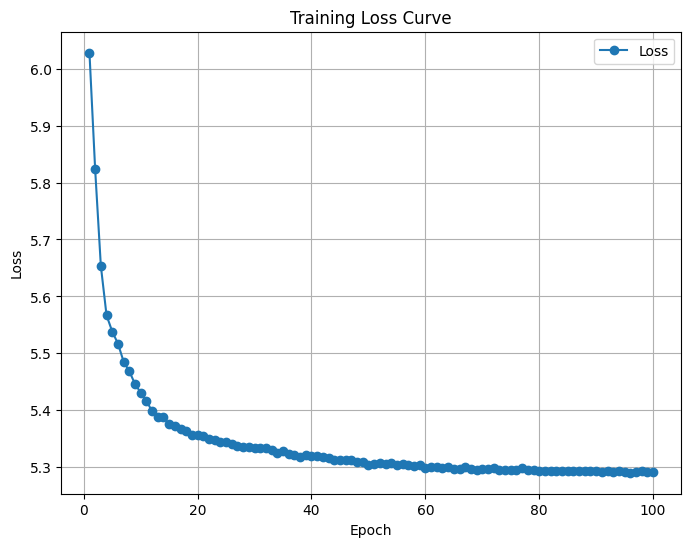

In [10]:

# 合并训练集和测试集
merged_train_truth = merge_train_test(train_truth, test_truth, (349, 1905))

# 应用 PCA 降维
pca_data = casi  # 使用原始的高光谱数据


# 执行超像素分割
superpixel_labels = superpixel_segmentation(casi)

# 计算超像素 PCA（仅使用训练区域）
superpixel_pca_map, superpixel_pca_dict = compute_superpixel_pca(casi, superpixel_labels, merged_train_truth)

# 计算全局 PCA（仅使用训练区域）
global_pca_map = compute_global_pca(casi, merged_train_truth, num_components=144)




# 初始化数据集（正确）
dataset = S3PCADataset(pca_data, superpixel_pca_map, superpixel_pca_dict, superpixel_labels, global_pca_map)


# 创建数据加载器
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# 初始化网络
feature_extractor = FeatureExtractor(input_channels=216).cuda()  
projection_head = ProjectionHead(input_dim=128, output_dim=8).cuda()
optimizer = optim.Adam(list(feature_extractor.parameters()) + list(projection_head.parameters()), lr=1e-4)

# 创建保存模型的文件夹
os.makedirs('./pth', exist_ok=True)

# 训练循环
num_epochs = 100
temperature = 1.0
loss_values = []

for epoch in range(num_epochs):
    feature_extractor.train()
    projection_head.train()
    
    epoch_loss = 0
    for batch in dataloader:
        cube_a, cube_b = batch
        cube_a, cube_b = cube_a.cuda(), cube_b.cuda()
        
        features_a = feature_extractor(cube_a)
        features_b = feature_extractor(cube_b)
        
        proj_a = projection_head(features_a)
        proj_b = projection_head(features_b)
        
        loss = contrastive_loss(proj_a, proj_b, temperature)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    loss_values.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# 仅保存最后一个模型
model_path = 'pth/S3PCA_merge_fulld_v1.pth'
torch.save(
    {
        'epoch': num_epochs,
        'feature_extractor_state_dict': feature_extractor.state_dict(),
        'projection_head_state_dict': projection_head.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_values[-1],
    },
    model_path
)
print(f"Final model saved to {model_path}")

# 绘制损失曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.savefig('pth/loss_curve_S3PCA_merge_fulld_v1.png')
plt.show()


In [11]:
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import random
from collections import defaultdict
import numpy as np
import torch
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
def extract_labels(truth, label_dict):
    """
    从稀疏矩阵中提取标注数据，格式为 [(row, col, label), ...]。
    并将标签值映射到 [0, len(label_dict)-1] 的范围。
    """
    rows, cols, labels = truth.row, truth.col, truth.data
    # 创建从标签值到索引的映射
    label_to_index = {label_value: idx for idx, label_value in enumerate(label_dict.keys())}
    mapped_labels = [label_to_index[label] for label in labels if label in label_to_index]
    return [(row, col, label) for row, col, label in zip(rows, cols, mapped_labels)]


# 提取立方块函数
def extract_cube(data, x, y, size):
    """
    从高光谱图像中提取一个立方块，并在边缘不足时进行填充。
    参数:
        data: 高光谱数据, 形状为 [C, H, W]
        x, y: 中心像素的坐标
        size: 立方块的大小 (s, s)
    返回:
        cube: 提取的立方块, 形状为 [C, s, s]
    """
    c, h, w = data.shape
    half_size = size[0] // 2
    x_min = max(0, x - half_size)
    x_max = min(h, x + half_size + 1)
    y_min = max(0, y - half_size)
    y_max = min(w, y + half_size + 1)
    
    cube = data[:, x_min:x_max, y_min:y_max]

    # 对称填充，确保形状为 (C, s, s)
    pad_width = [
        (0, 0),  # 不填充通道维度
        (max(0, half_size - x), max(0, x + half_size + 1 - h)),  # 高度填充
        (max(0, half_size - y), max(0, y + half_size + 1 - w)),  # 宽度填充
    ]
    cube = np.pad(cube, pad_width, mode="reflect")
    return cube


# PCA 降维函数
def apply_pca_train_only(hsi_data, train_truth, num_components=20):
    """
    使用训练区域的光谱数据训练 PCA 模型，并应用到整个数据集。
    参数:
        hsi_data: 高光谱数据, 形状为 [C, H, W]
        train_truth: coo_array, 训练区域的稀疏矩阵，表示训练样本的位置
        num_components: 保留的主成分数量
    返回:
        pca_data: 降维后的数据, 形状为 [num_components, H, W]
        explained_variance_ratio: PCA 的累计解释方差比
    """
    c, h, w = hsi_data.shape
    rows, cols = train_truth.row, train_truth.col  # 提取训练区域的行列索引

    # 提取训练区域的光谱数据 [num_samples, num_channels]
    train_spectra = hsi_data[:, rows, cols].T  # 转置为 [num_samples, num_channels]

    # 在训练区域数据上拟合 PCA
    pca = PCA(n_components=num_components)
    pca.fit(train_spectra)  # 仅在训练区域数据上训练 PCA

    # 转换整个数据集
    reshaped_data = hsi_data.reshape(c, -1).T  # [H×W, C]
    reduced_data = pca.transform(reshaped_data)  # 降维 [H×W, num_components]

    # 恢复为原始图像的形状
    pca_data = reduced_data.T.reshape(num_components, h, w)  # [num_components, H, W]
    
    return pca_data, pca.explained_variance_ratio_


# 分类数据集定义
class ClassificationDataset(Dataset):
    def __init__(self, data, labels, superpixel_pca_dict, superpixel_labels, patch_size=11):
        """
        分类数据集，构建和对比学习一致的输入（216通道）。
        data: 原始高光谱数据 [C, H, W]
        labels: [(x, y, label), ...]
        superpixel_pca_dict: {label: ndarray of shape (C, N)}
        superpixel_labels: (H, W)
        """
        self.data = data
        self.labels = labels
        self.superpixel_pca_dict = superpixel_pca_dict
        self.superpixel_labels = superpixel_labels
        self.patch_size = patch_size
        self.h, self.w = data.shape[1], data.shape[2]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x, y, label = self.labels[idx]

        # 1. 提取原始 patch
        raw_patch = extract_cube(self.data, x, y, (self.patch_size, self.patch_size))
        raw_patch = raw_patch.astype(np.float32)
        raw_patch = torch.tensor(raw_patch, dtype=torch.float32)

        # 2. 拆出 72 通道
        raw_patch_a, _ = torch.split(raw_patch, [72, 72], dim=0)

        # 3. 提取 superpixel 平均特征
        superpixel_feat = extract_precise_superpixel_pca(self.superpixel_pca_dict, self.superpixel_labels, x, y)
        superpixel_feat = torch.tensor(superpixel_feat[:, None, None], dtype=torch.float32)
        superpixel_patch = superpixel_feat.expand(-1, self.patch_size, self.patch_size)

        # 4. 拼接为 216 通道
        input_patch = torch.cat([raw_patch_a, superpixel_patch], dim=0)

        return input_patch, label



# 候选集生成函数
def create_candidate_dataset(train_labels, num_classes, samples_per_class):
    """
    从训练样本中按每类抽取指定数量的样本，构造候选集。
    参数:
        train_labels: 原始训练样本 [(row, col, label), ...]
        num_classes: 类别数量
        samples_per_class: 每个类别抽取的样本数量
    返回:
        candidate_labels: 候选样本 [(row, col, label), ...]
    """
    class_samples = defaultdict(list)
    for sample in train_labels:
        class_samples[sample[2]].append(sample)

    candidate_labels = []
    for cls in range(num_classes):
        if cls in class_samples:
            samples = class_samples[cls]
            if len(samples) < samples_per_class:
                print(f"Warning: Class {cls} has only {len(samples)} samples, less than {samples_per_class}.")
            candidate_labels.extend(random.sample(samples, min(samples_per_class, len(samples))))
        else:
            print(f"Warning: Class {cls} has no samples in training set.")
    return candidate_labels


# 定义特征提取器
class FeatureExtractor(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)  # Flatten to [batch_size, features]



In [6]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)


In [13]:
num_classes = len(set(train_truth.data))
test_labels = extract_labels(test_truth, info['label_dict'])


test_label_counts = Counter([label for _, _, label in test_labels])



candidate_labels = create_candidate_dataset(test_labels, num_classes=len(info['label_dict']), samples_per_class=10)
test_dataset = ClassificationDataset(
    data=casi,
    labels=test_labels,
    superpixel_pca_dict=superpixel_pca_dict,
    superpixel_labels=superpixel_labels,
    patch_size=11
)

candidate_dataset = ClassificationDataset(
    data=casi,
    labels=candidate_labels,
    superpixel_pca_dict=superpixel_pca_dict,
    superpixel_labels=superpixel_labels,
    patch_size=11
)


# 定义数据加载器
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
candidate_loader = DataLoader(candidate_dataset, batch_size=64, shuffle=True)

# 打印样本数量信息

print(f"Number of candidate samples: {len(candidate_loader.dataset)}")
print(f"Number of testing samples: {len(test_loader.dataset)}")


# 加载对比学习的模型权重
#checkpoint_path = "./pth/model_epoch_160.pth"  # 修改为对比学习模型的路径
checkpoint_path = "pth/S3PCA_merge_fulld_v1.pth"
checkpoint = torch.load(checkpoint_path)


# 确保权重文件中包含特征提取器的权重
if 'feature_extractor_state_dict' not in checkpoint:
    raise KeyError("Checkpoint does not contain 'feature_extractor_state_dict'. Please check the file.")

Number of candidate samples: 150
Number of testing samples: 12197


In [14]:

# 初始化特征提取器（与对比学习阶段一致的输入通道数为 20）
feature_extractor = FeatureExtractor(input_channels=216).cuda()

# 加载所有预训练权重
feature_extractor.load_state_dict(checkpoint['feature_extractor_state_dict'])
print("Loaded pre-trained weights for the entire feature extractor.")

# 检查冻结状态（设置所有层参数为可微调）
for param in feature_extractor.parameters():
    param.requires_grad = True  # 解冻所有参数

# 定义分类头
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# 修改输入维度为 128（特征提取器的输出维度）
classification_head = ClassificationHead(input_dim=128, num_classes=15).cuda()

# 定义优化器
optimizer = optim.Adam([
    {"params": feature_extractor.parameters(), "lr": 1e-4},  # 微调特征提取器
    {"params": classification_head.parameters(), "lr": 1e-3},  # 分类头
])

# 定义损失函数
criterion = nn.CrossEntropyLoss()

loss_values = []

def train_classification_model(feature_extractor, classification_head, train_loader, optimizer, criterion, num_epochs=50):
    feature_extractor.train()
    classification_head.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for cubes, labels in train_loader:
            cubes, labels = cubes.cuda(), labels.cuda()
            features = feature_extractor(cubes)
            outputs = classification_head(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_values.append(avg_loss)  # 记录损失值

        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# 运行训练函数
train_classification_model(feature_extractor, classification_head, candidate_loader, optimizer, criterion, num_epochs=200)



Loaded pre-trained weights for the entire feature extractor.


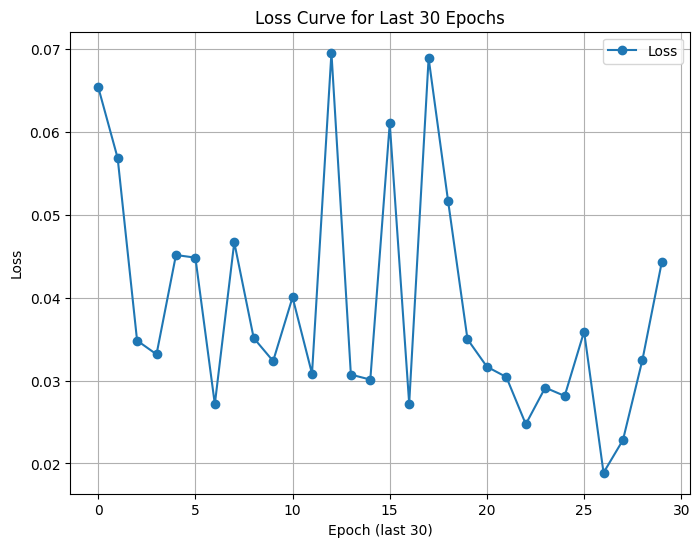

In [15]:
import matplotlib.pyplot as plt

# 取最后 30 轮的 loss
last_30_losses = loss_values[-30:]

# 绘制损失曲线
plt.figure(figsize=(8, 6))
plt.plot(range(len(last_30_losses)), last_30_losses, marker='o', linestyle='-', label='Loss')
plt.xlabel('Epoch (last 30)')
plt.ylabel('Loss')
plt.title('Loss Curve for Last 30 Epochs')
plt.legend()
plt.grid()
plt.show()


In [16]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

def evaluate_classification_model_with_details(feature_extractor, classification_head, test_loader, num_classes):
    """
    评估分类模型的性能，并输出详细预测结果和分布。

    参数:
        feature_extractor: 冻结的特征提取器
        classification_head: 分类头
        test_loader: 测试数据加载器
        num_classes: 总类别数
    """
    feature_extractor.eval()
    classification_head.eval()

    correct = 0
    total = 0

    # 初始化预测计数，并移动到 GPU
    prediction_counts = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_correct = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_total = torch.zeros(num_classes, dtype=torch.int64).cuda()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for cubes, labels in test_loader:
            cubes, labels = cubes.cuda(), labels.cuda()

            # 提取特征并进行预测
            features = feature_extractor(cubes)
            outputs = classification_head(features)
            _, predicted = torch.max(outputs, 1)

            # 更新统计信息
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            prediction_counts += torch.bincount(predicted, minlength=num_classes).cuda()

            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

            # 保存详细信息
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Overall Accuracy
    overall_accuracy = correct / total

    # Average Accuracy (每个类别的平均准确率)
    average_accuracy = (class_correct.float() / class_total.float()).mean().item()

    # Kappa 系数
    kappa = cohen_kappa_score(all_labels, all_predictions)

    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Average Accuracy: {average_accuracy:.4f}")
    print(f"Kappa Coefficient: {kappa:.4f}")

    print("\nPrediction Distribution:")
    for cls, count in enumerate(prediction_counts.cpu()):  # 将分布从 GPU 移回 CPU
        print(f"Class {cls}: {count} predictions")

    return overall_accuracy, average_accuracy, kappa, all_predictions, all_labels

# 再次评估模型
overall_accuracy, average_accuracy, kappa, all_predictions, all_labels = evaluate_classification_model_with_details(
    feature_extractor, classification_head, test_loader, num_classes=num_classes
)

# 打印所有测试样本的预测类别和真实类别
print("\nDetailed Predictions:")
for idx, (pred, label) in enumerate(zip(all_predictions, all_labels)):
    print(f"Sample {idx}: Predicted={pred}, True={label}")

Overall Accuracy: 0.7643
Average Accuracy: 0.8033
Kappa Coefficient: 0.7444

Prediction Distribution:
Class 0: 962 predictions
Class 1: 1141 predictions
Class 2: 493 predictions
Class 3: 1235 predictions
Class 4: 1031 predictions
Class 5: 206 predictions
Class 6: 1052 predictions
Class 7: 701 predictions
Class 8: 708 predictions
Class 9: 1704 predictions
Class 10: 775 predictions
Class 11: 1033 predictions
Class 12: 357 predictions
Class 13: 247 predictions
Class 14: 552 predictions

Detailed Predictions:
Sample 0: Predicted=1, True=0
Sample 1: Predicted=0, True=0
Sample 2: Predicted=0, True=0
Sample 3: Predicted=0, True=0
Sample 4: Predicted=0, True=0
Sample 5: Predicted=0, True=0
Sample 6: Predicted=0, True=0
Sample 7: Predicted=1, True=0
Sample 8: Predicted=1, True=0
Sample 9: Predicted=1, True=0
Sample 10: Predicted=1, True=0
Sample 11: Predicted=1, True=0
Sample 12: Predicted=1, True=0
Sample 13: Predicted=1, True=0
Sample 14: Predicted=1, True=0
Sample 15: Predicted=0, True=0
Sam

C:\Users\A\AppData\Local\Temp\ipykernel_3780\1956347060.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(models, rotation=20)
C:\Users\A\AppData\Local\Temp\ipykernel_3780\1956347060.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(models, rotation=20)
C:\Users\A\AppData\Local\Temp\ipykernel_3780\1956347060.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(models, rotation=20)


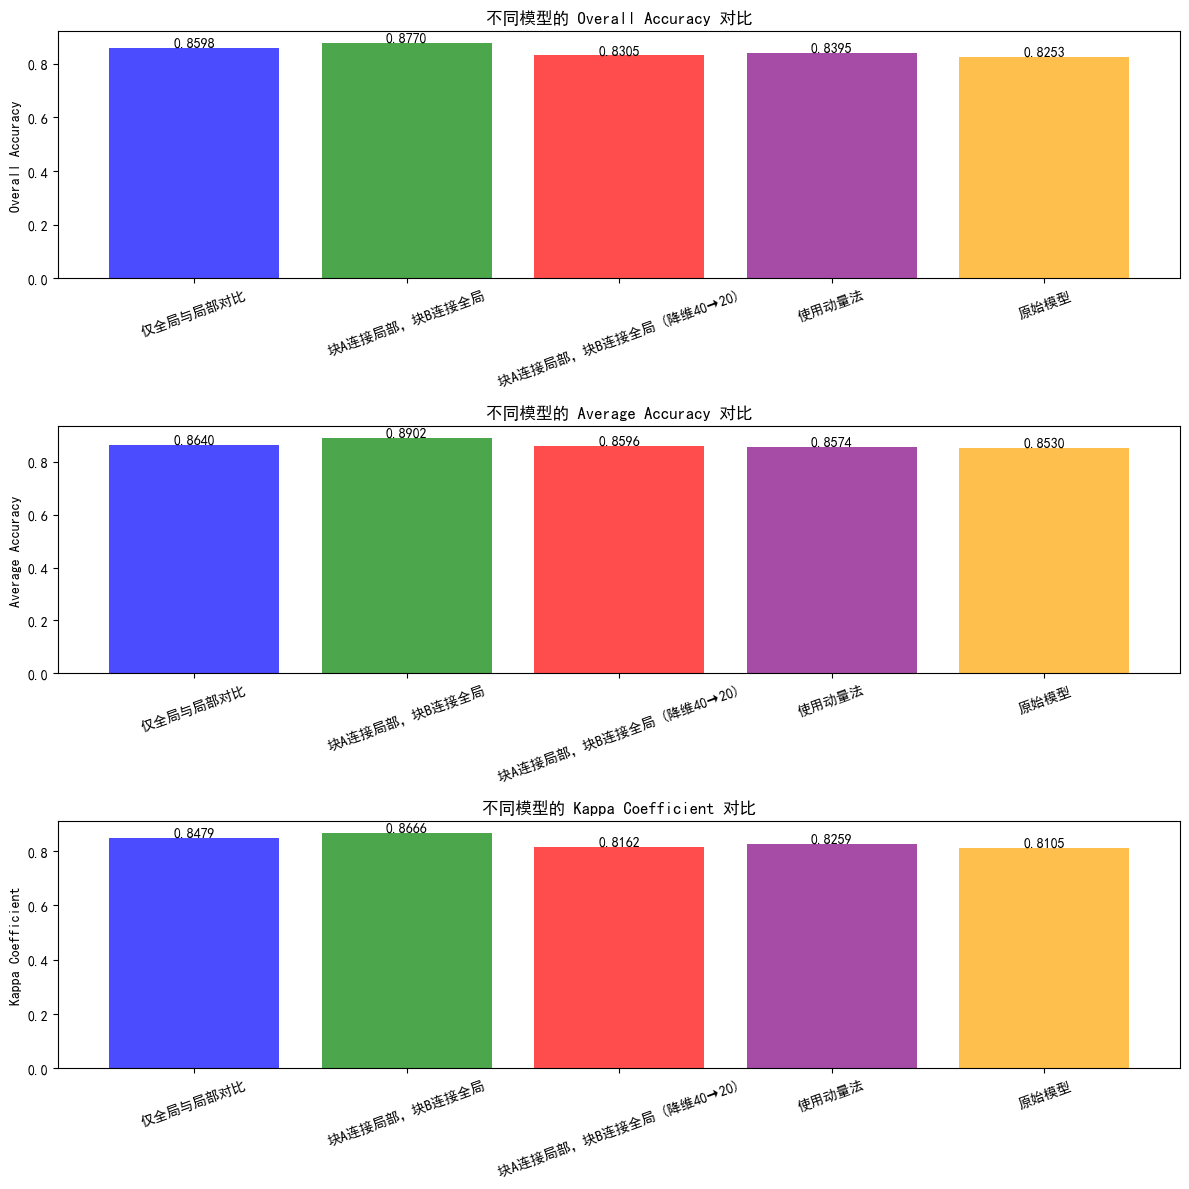

In [18]:
import matplotlib.pyplot as plt

# 解决中文显示问题
plt.rcParams["font.family"] = "SimHei"  # 使用黑体支持中文
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# 定义不同模型的名称
models = [
    "仅全局与局部对比",
    "块A连接局部，块B连接全局",
    "块A连接局部，块B连接全局 (降维40→20)",
    "使用动量法",
    "原始模型"
]

# 定义不同模型的评估指标
overall_accuracy = [0.8598, 0.8770, 0.8305, 0.8395, 0.8253]
average_accuracy = [0.8640, 0.8902, 0.8596, 0.8574, 0.8530]
kappa_coefficient = [0.8479, 0.8666, 0.8162, 0.8259, 0.8105]

# 颜色列表
colors = ['blue', 'green', 'red', 'purple', 'orange']

# 设置图像大小
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# 绘制 Overall Accuracy 对比柱状图
axes[0].bar(models, overall_accuracy, color=colors, alpha=0.7)
for i, v in enumerate(overall_accuracy):
    axes[0].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=10)
axes[0].set_ylabel("Overall Accuracy")
axes[0].set_title("不同模型的 Overall Accuracy 对比")
axes[0].set_xticklabels(models, rotation=20)

# 绘制 Average Accuracy 对比柱状图
axes[1].bar(models, average_accuracy, color=colors, alpha=0.7)
for i, v in enumerate(average_accuracy):
    axes[1].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=10)
axes[1].set_ylabel("Average Accuracy")
axes[1].set_title("不同模型的 Average Accuracy 对比")
axes[1].set_xticklabels(models, rotation=20)

# 绘制 Kappa Coefficient 对比柱状图
axes[2].bar(models, kappa_coefficient, color=colors, alpha=0.7)
for i, v in enumerate(kappa_coefficient):
    axes[2].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=10)
axes[2].set_ylabel("Kappa Coefficient")
axes[2].set_title("不同模型的 Kappa Coefficient 对比")
axes[2].set_xticklabels(models, rotation=20)

# 调整布局并显示图像
plt.tight_layout()
plt.show()


C:\Users\A\AppData\Local\Temp\ipykernel_3780\1015233050.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(models, rotation=20)
C:\Users\A\AppData\Local\Temp\ipykernel_3780\1015233050.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(models, rotation=20)
C:\Users\A\AppData\Local\Temp\ipykernel_3780\1015233050.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(models, rotation=20)
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial 

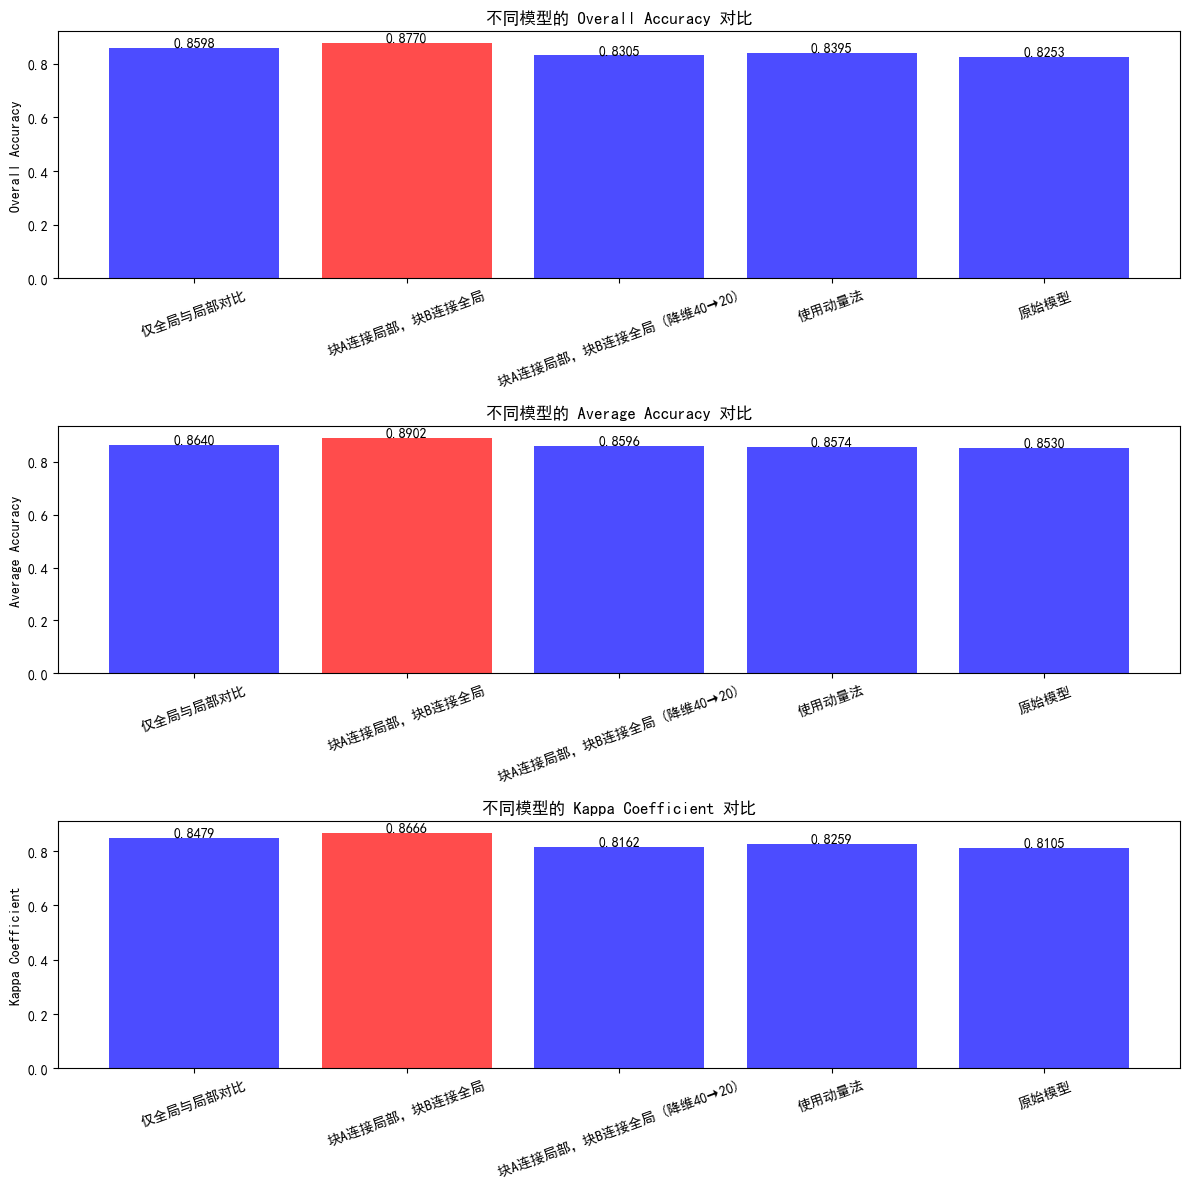

In [19]:
import matplotlib.pyplot as plt

# 解决中文显示问题
plt.rcParams["font.family"] = ["Arial Unicode MS", "SimHei"]  # 兼容不同系统
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# 定义不同模型的名称
models = [
    "仅全局与局部对比",
    "块A连接局部，块B连接全局",
    "块A连接局部，块B连接全局 (降维40→20)",
    "使用动量法",
    "原始模型"
]

# 定义不同模型的评估指标
overall_accuracy = [0.8598, 0.8770, 0.8305, 0.8395, 0.8253]
average_accuracy = [0.8640, 0.8902, 0.8596, 0.8574, 0.8530]
kappa_coefficient = [0.8479, 0.8666, 0.8162, 0.8259, 0.8105]

# 找到最高值对应的索引
best_overall_index = overall_accuracy.index(max(overall_accuracy))
best_average_index = average_accuracy.index(max(average_accuracy))
best_kappa_index = kappa_coefficient.index(max(kappa_coefficient))

# 颜色列表
colors = ['blue'] * len(models)
highlight_color = 'red'  # 最高值柱子高亮颜色

# 设置图像大小
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# 绘制 Overall Accuracy 对比柱状图
axes[0].bar(models, overall_accuracy, color=[highlight_color if i == best_overall_index else colors[i] for i in range(len(models))], alpha=0.7)
for i, v in enumerate(overall_accuracy):
    axes[0].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=10)
axes[0].set_ylabel("Overall Accuracy")
axes[0].set_title("不同模型的 Overall Accuracy 对比")
axes[0].set_xticklabels(models, rotation=20)

# 绘制 Average Accuracy 对比柱状图
axes[1].bar(models, average_accuracy, color=[highlight_color if i == best_average_index else colors[i] for i in range(len(models))], alpha=0.7)
for i, v in enumerate(average_accuracy):
    axes[1].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=10)
axes[1].set_ylabel("Average Accuracy")
axes[1].set_title("不同模型的 Average Accuracy 对比")
axes[1].set_xticklabels(models, rotation=20)

# 绘制 Kappa Coefficient 对比柱状图
axes[2].bar(models, kappa_coefficient, color=[highlight_color if i == best_kappa_index else colors[i] for i in range(len(models))], alpha=0.7)
for i, v in enumerate(kappa_coefficient):
    axes[2].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=10)
axes[2].set_ylabel("Kappa Coefficient")
axes[2].set_title("不同模型的 Kappa Coefficient 对比")
axes[2].set_xticklabels(models, rotation=20)

# 调整布局并显示图像
plt.tight_layout()
plt.show()
